## Intro 
In this notebook we will apply knowledge gathered from bacteria famillies analysis to KEGG pathways dataset, main difference between those we can expect is higher number of features and more highly corelated data.  

### Import libraries and load data

In [104]:
#libraries import
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
# for tensorboard logs
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.preprocessing import normalize
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split, KFold
from functions import *
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE, SMOTEN

np.random.seed(111)
tf.random.set_seed(111)


In [105]:
df = pd.read_csv('https://raw.githubusercontent.com/paq88/Fish_neural_network_classifier/refs/heads/main/sed_based/Data/sed_KEGG_paths_merged.csv')


In [106]:
print(df.shape)
df.head()

(50, 238)


,pond,ko05340,ko00564,ko00680,ko00562,ko00563,ko03030,ko00561,ko00440,ko00250,...,ko05412,ko00905,ko03015,ko05414,ko04320,ko04740,ko05214,ko04745,ko04012,ko04722
0,S8.201.Sed,2483.06,46002.51,73354.01,12921.62,55.0,52097.75,23289.22,2725.06,76990.24,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,S8.202.Sed,3736.83,57196.57,102558.53,16078.17,0.0,67388.46,31995.86,3786.00,100060.80,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,S9.231.Sed,2464.17,45408.79,72940.07,12974.68,0.0,52935.25,23597.27,2433.42,76317.49,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,S9.232.Sed,5169.91,53418.09,98344.53,15092.31,0.0,65909.03,29807.71,3249.49,98762.58,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,S10.222.Sed,1532.00,26319.19,46407.43,7309.02,0.0,32166.21,14235.97,1371.59,48799.16,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [107]:
predictors = df.columns[1:]
print(f"number of predictors/bacteria famillies: {len(predictors)}")
      
# adding collumn with timepoints 
classes = np.tile([0, 1], 25)
df.insert(1,"timepoint",  classes)

# replacing NaN values with 0
df.fillna(0, inplace=True)

df.head()



number of predictors/bacteria famillies: 237


,pond,timepoint,ko05340,ko00564,ko00680,ko00562,ko00563,ko03030,ko00561,ko00440,...,ko05412,ko00905,ko03015,ko05414,ko04320,ko04740,ko05214,ko04745,ko04012,ko04722
0,S8.201.Sed,0,2483.06,46002.51,73354.01,12921.62,55.0,52097.75,23289.22,2725.06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,S8.202.Sed,1,3736.83,57196.57,102558.53,16078.17,0.0,67388.46,31995.86,3786.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,S9.231.Sed,0,2464.17,45408.79,72940.07,12974.68,0.0,52935.25,23597.27,2433.42,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,S9.232.Sed,1,5169.91,53418.09,98344.53,15092.31,0.0,65909.03,29807.71,3249.49,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,S10.222.Sed,0,1532.00,26319.19,46407.43,7309.02,0.0,32166.21,14235.97,1371.59,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [108]:
# for normalisation we will use starndard min-max normalisation
df[predictors] = normalize(df[predictors], norm='max', axis=0, copy=True, return_norm=False)
df.describe()

,timepoint,ko05340,ko00564,ko00680,ko00562,ko00563,ko03030,ko00561,ko00440,ko00250,...,ko05412,ko00905,ko03015,ko05414,ko04320,ko04740,ko05214,ko04745,ko04012,ko04722
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,...,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.500000,0.427981,0.489505,0.498134,0.559149,0.030909,0.506057,0.540151,0.490196,0.531252,...,0.065455,0.081739,0.055135,0.080000,0.065455,0.027500,0.027500,0.027500,0.027500,0.027500
std,0.505076,0.204134,0.197568,0.194754,0.217259,0.151018,0.196681,0.212624,0.228835,0.203750,...,0.236663,0.212934,0.169793,0.254194,0.236663,0.150021,0.150021,0.150021,0.150021,0.150021
min,0.000000,0.052225,0.052410,0.052397,0.061102,0.000000,0.050122,0.055485,0.063806,0.052093,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.298748,0.355653,0.384165,0.421461,0.000000,0.390621,0.408219,0.311749,0.414260,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,0.390221,0.476028,0.500701,0.541827,0.000000,0.484009,0.519813,0.482618,0.515067,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.505913,0.616061,0.618313,0.697781,0.000000,0.624554,0.679154,0.630388,0.661848,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000




| number | setup | pond numbers | water supplementation | feed supplementation |
|---|---|---|---|---|
|0|control | 8,14,18,24,29|NO|NO|
|1|set 1 | 12,16,19,23,26|Em farma|NO|
|2|set 2 | 10,21,28,30,32|Em farma|EM|
|3|set 3 | 9,13,17,20,27|EM|NO|
|4|set 4 | 11,15,22,25,31|EM|EM|

In [109]:
df['pond_org'] = df['pond']

C:\Users\marek\AppData\Local\Temp\ipykernel_22648\3039816547.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['pond_org'] = df['pond']


In [110]:
df['pond_org']

0      S8.201.Sed
1      S8.202.Sed
2      S9.231.Sed
3      S9.232.Sed
4     S10.222.Sed
5     S10.221.Sed
6     S11.242.Sed
7     S11.241.Sed
8     S12.212.Sed
9     S12.211.Sed
10    S13.233.Sed
11    S13.234.Sed
12    S14.203.Sed
13    S14.204.Sed
14    S15.244.Sed
15    S15.243.Sed
16    S16.213.Sed
17    S16.214.Sed
18    S17.236.Sed
19    S17.235.Sed
20    S18.206.Sed
21    S18.205.Sed
22    S19.216.Sed
23    S19.215.Sed
24    S20.237.Sed
25    S20.238.Sed
26    S21.223.Sed
27    S21.224.Sed
28    S22.246.Sed
29    S22.245.Sed
30    S23.217.Sed
31    S23.218.Sed
32    S24.207.Sed
33    S24.208.Sed
34    S25.247.Sed
35    S25.248.Sed
36    S26.219.Sed
37    S26.220.Sed
38    S27.239.Sed
39    S27.240.Sed
40    S28.225.Sed
41    S28.226.Sed
42    S29.209.Sed
43    S29.210.Sed
44    S30.227.Sed
45    S30.228.Sed
46    S31.249.Sed
47    S31.250.Sed
48    S32.230.Sed
49    S32.229.Sed
Name: pond_org, dtype: object

In [111]:
# Decoding use pond decoder 2 for this

codes = {0 : [8,14,18,24,29], 1: [12,16,19,23,26], 2 : [10,21,28,30,32], 3 : [9,13,17,20,27], 4 : [11,15,22,25,31]}

df['pond']=df['pond_org'].apply(lambda x: pond_decoder_2(x, codes))


In [112]:
control_id = (df['timepoint'] == 0) | ((df['timepoint'] == 1) & (df['pond'] == 0))



In [113]:
df.loc[control_id, 'class'] = 0 
df.loc[df['class']!=0,'class'] = df.loc[df['class']!=0,'pond']

C:\Users\marek\AppData\Local\Temp\ipykernel_22648\3401523952.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[control_id, 'class'] = 0


In [114]:
# defragmenting 
df = df.copy()

In [115]:
#train_val_df, test_df = train_test_split(df, test_size= 10, random_state=111, stratify=df['pondXtime'])
#print(train_val_df.shape, test_df.shape)

### Definitions

In [116]:
kf = KFold(n_splits=5, shuffle=True, random_state=111)


In [117]:
# early stopping callback to save the best model weights for test set
es_callback = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=100,         # Number of epochs with no improvement after which training will be stopped
    verbose=1,           # Verbosity mode
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

### Modelling without oversampling
We will start with made most sense form biological perspective: by using as controll all observations from tp 0 plus controll from tp 1


In [118]:
model1 = keras.Sequential()



model1.add(keras.layers.Dense(128,input_shape=(len(predictors),),activation='relu'))


model1.add(keras.layers.Dropout(rate=0.25))
model1.add(keras.layers.Dense(64, activation ='relu'))
model1.add(keras.layers.Dense(16, activation ='relu'))
model1.add(keras.layers.Dropout(rate=0.25))
model1.add(keras.layers.Dense(16, activation ='relu'))

model1.add(keras.layers.Dense(5, activation ='softmax'))

print(model1.summary())


loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model1.compile(optimizer = optimizer, loss = loss, metrics=metrics)

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_39 (Dense)                │ (None, 128)            │        30,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,117 (156.71 KB)

 Trainable params: 40,117 (156.71 KB)

 Non-trainable params: 0 (0.00 B)

None


Number of classes: 5
training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.6000 - loss: 1.7895
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
predicted classes:       [0 0 0 0 0 0 0 0 0 0]
true validation classes: [0 0 1 4 0 1 0 0 4 0]
mean confidence score: 41.975, sd confidence score: 70.7692
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5000 - loss: 1.8429
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
predicted classes:       [0 0 0 0 0 0 0 0 0 0]
true validation classes: [3 0 1 3 4 1 0 0 0 0]
mean confidence score: 9.6345, sd confidence score: 9.1119
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5000 - loss: 1.9736
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
predicted classes:       [0 0 0 0 0 0 0 0 0 0]
true validation classes: [2 0 0 0 3 0 2 0 1 2]
mean confidence score: 20.7443, sd confidence score: 21.969
training for 4 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5000 - loss: 1.1982
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

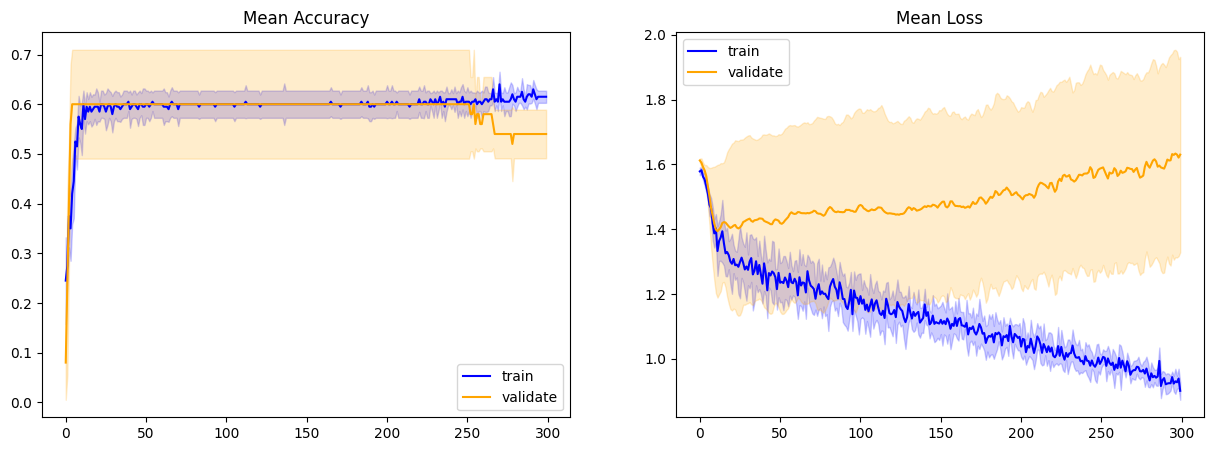

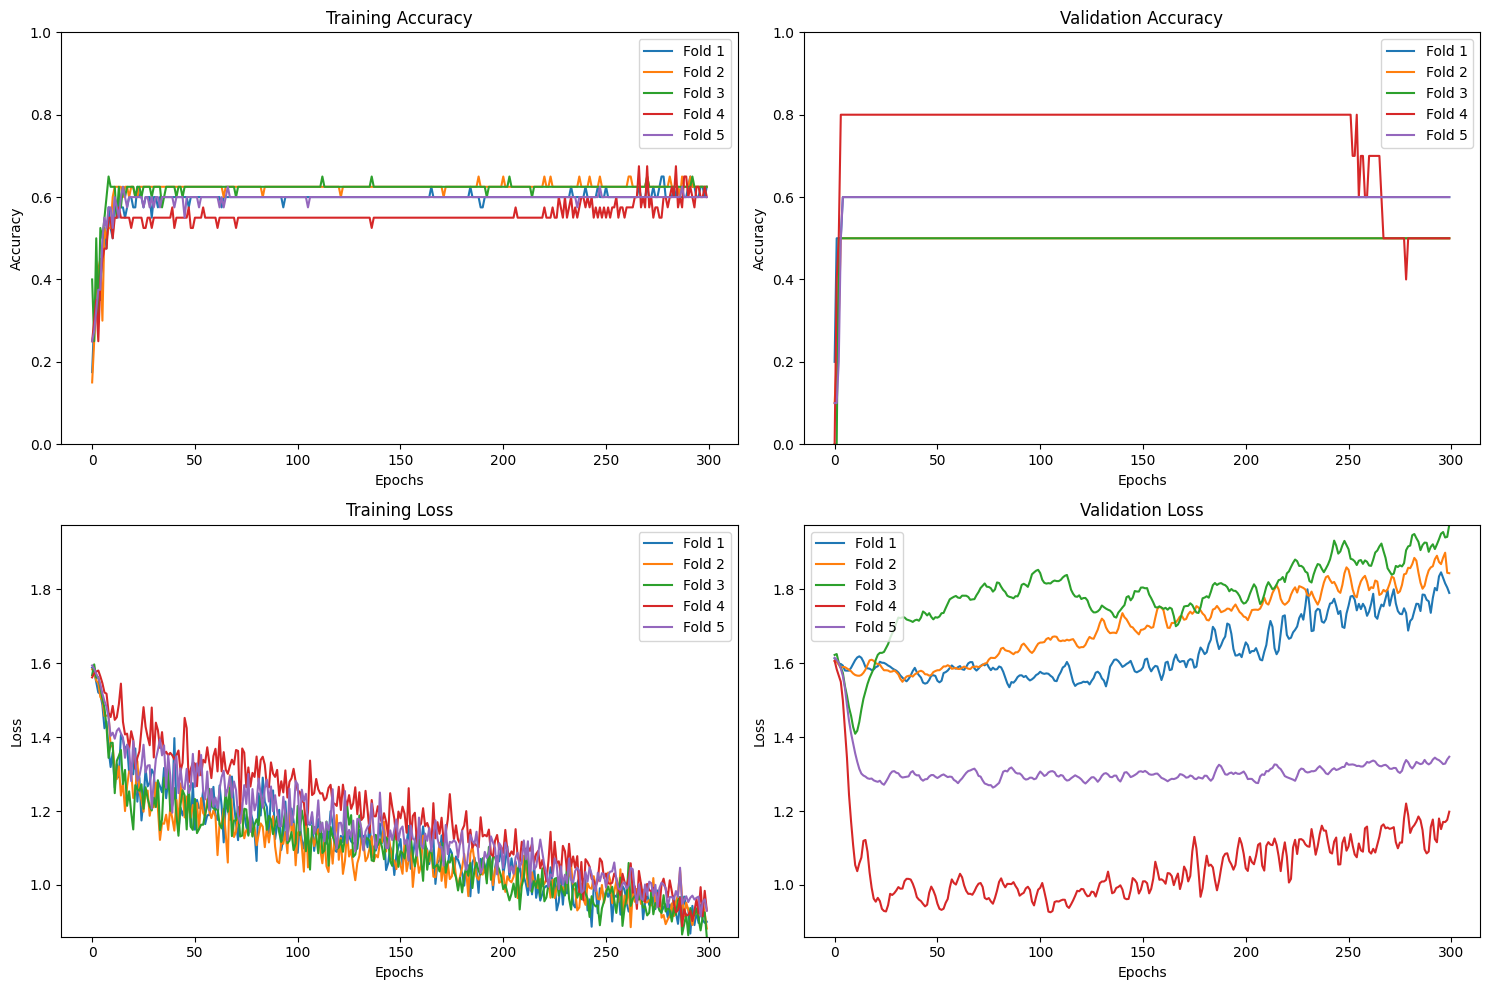

In [119]:
crossvalidate(df, model1, predictors, 'class', kf)

We can see the results are the same as for bacteria dataset, with problems caused by overrepresentation.

### Oversampling 1:4 classes
For oversampling we will again use SMOTE algorythm as it is more sophisticated than just duplicating.

In [120]:
train_val_df, test_df = train_test_split(df, test_size= 10, random_state=111, stratify=df['class'])
train_val_df.shape, test_df.shape

((40, 241), (10, 241))

In [121]:
smote = SMOTE(random_state=111, sampling_strategy='not majority', k_neighbors=3)
X = train_val_df[predictors].values
y = train_val_df['class']

 

In [122]:
# Ensure y contains discrete class labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_smote, y_smote = smote.fit_resample(X, y_encoded)

In [123]:
print(X.shape, y.shape)
print(X_smote.shape, y_smote.shape)

(40, 237) (40,)
(120, 237) (120,)


In [124]:
df_smote = pd.concat([pd.DataFrame(X_smote, columns=predictors), pd.DataFrame(y_smote, columns=['class'])], axis=1)
df_smote['class'].value_counts()

class
0    24
4    24
3    24
1    24
2    24
Name: count, dtype: int64

#### Modeling oversampled dataset

In [125]:
model2 = keras.Sequential()



model2.add(keras.layers.Dense(256,input_shape=(len(predictors),),activation='relu'))


model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(64, activation ='sigmoid'))
model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(16, activation ='sigmoid'))

model2.add(keras.layers.Dense(5, activation ='softmax'))

model2.summary()

loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model2.compile(optimizer = optimizer, loss = loss, metrics=metrics)

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_44 (Dense)                │ (None, 256)            │        60,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,501 (306.64 KB)

 Trainable params: 78,501 (306.64 KB)

 Non-trainable params: 0 (0.00 B)

Number of classes: 5
training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7917 - loss: 0.8217
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
predicted classes:       [0 4 1 1 1 1 4 4 0 0 1 1 1 2 3 3 3 3 3 3 3 4 4 4]
true validation classes: [0 4 3 1 1 0 0 0 0 0 0 1 1 2 3 3 3 3 3 3 3 4 4 4]
mean confidence score: 4.6217, sd confidence score: 3.0072
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9167 - loss: 0.7785
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
predicted classes:       [0 2 3 3 0 1 1 1 1 1 1 2 2 2 2 2 3 3 3 3 4 4 4 4]
true validation classes: [0 2 0 3 1 1 1 1 1 1 1 2 2 2 2 2 3 3 3 3 4 4 4 4]
mean confidence score: 3.5094, sd confidence score: 2.6788
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7500 - loss: 0.8860
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
predicted classes:       [2 3 4 2 1 1 1 1 2 2 2 2 3 3 3 3 3 4 2 0 4 2 4 4]
true validation classes: [0 3 0 2 0 1 1 1 2 2 2 2 3 3 3 3 3 4 4 4 4 4 4 4]
mean confidence

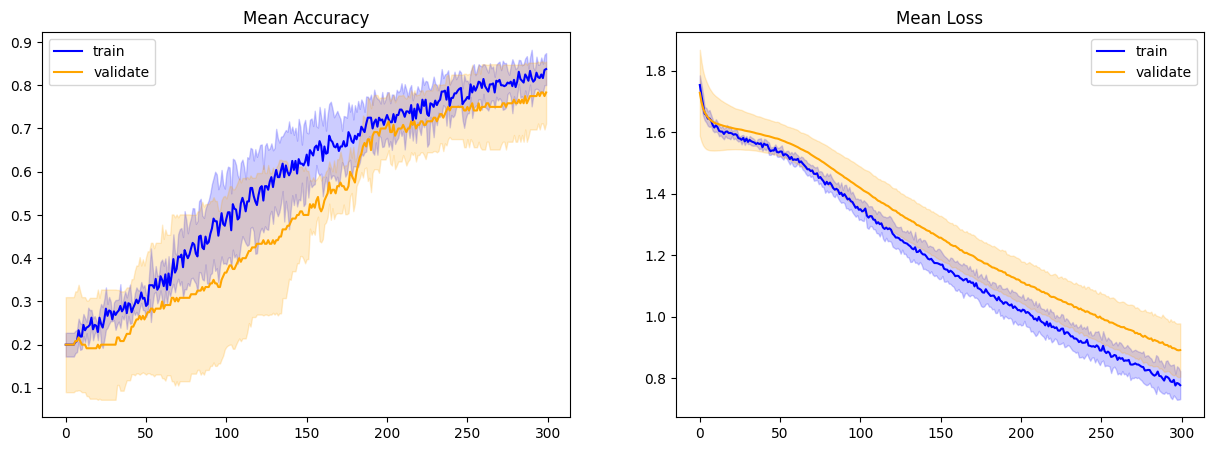

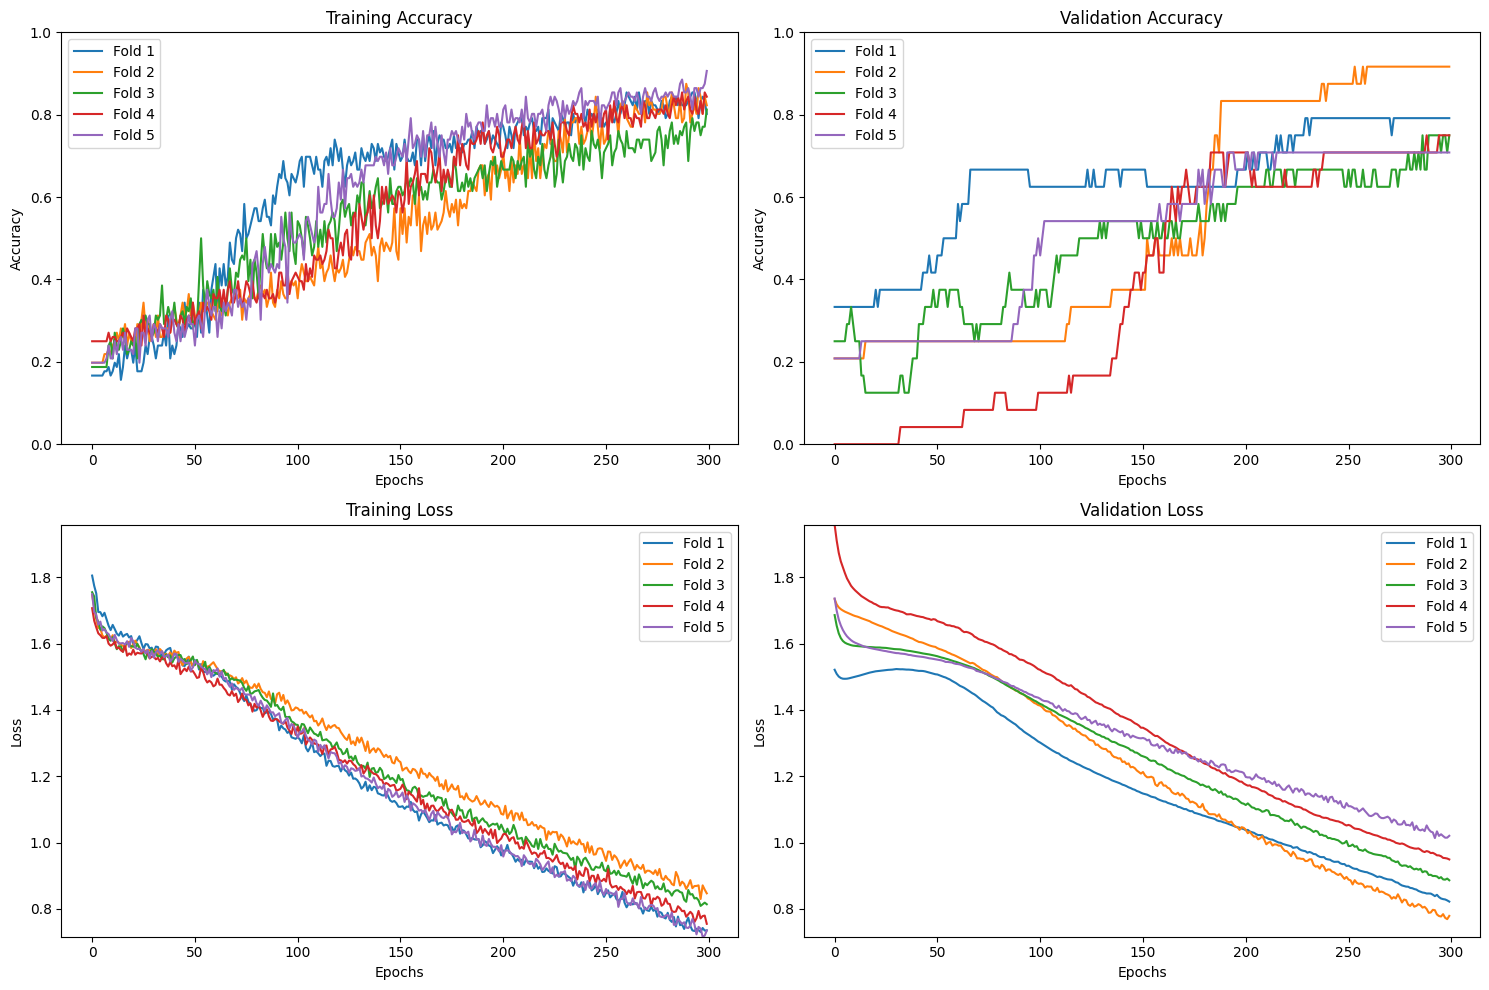

In [126]:
crossvalidate(df_smote, model2, predictors, 'class', kf)

As in bacteria dataset this approach is better than withour oversampling but we have to cosnider same problems as before, in addition accuracy is worse than for bacteria dataset, we will check resutls for test dataset now.

In [127]:
reset_weights(model2)
X_train_val = df_smote[predictors].values
y_train_val = keras.utils.to_categorical(df_smote['class'].values)
X_test = test_df[predictors].values
y_test = keras.utils.to_categorical(test_df['class'].values)
X_train_val.shape, y_train_val.shape, X_test.shape, y_test.shape


((120, 237), (120, 5), (10, 237), (10, 5))

In [128]:
history2 = model2.fit(X_train_val, y_train_val, validation_data = (X_test, y_test), epochs=500, callbacks=[es_callback], verbose=1)


Epoch 1/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.1602 - loss: 1.8248 - val_accuracy: 0.1000 - val_loss: 1.8528
Epoch 2/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1602 - loss: 1.8028 - val_accuracy: 0.1000 - val_loss: 1.8351
Epoch 3/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1602 - loss: 1.8043 - val_accuracy: 0.1000 - val_loss: 1.8212
Epoch 4/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1602 - loss: 1.7873 - val_accuracy: 0.1000 - val_loss: 1.8061
Epoch 5/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1602 - loss: 1.7938 - val_accuracy: 0.1000 - val_loss: 1.7901
Epoch 6/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1602 - loss: 1.7651 - val_accuracy: 0.1000 - val_loss: 1.7732
Epoch 7/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1602 - loss: 1.7509 - val_accuracy: 0.1000 - val_loss: 1.7558
Epoch 8/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1602 - loss: 1.7631 - val_accuracy: 0.1000 - val_loss:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2000 - loss: 1.5499
[1.5499203205108643, 0.20000000298023224]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted values: [0 3 3 0 0 3 3 3 0 0]
True values: [1 0 4 0 2 0 0 0 0 3]


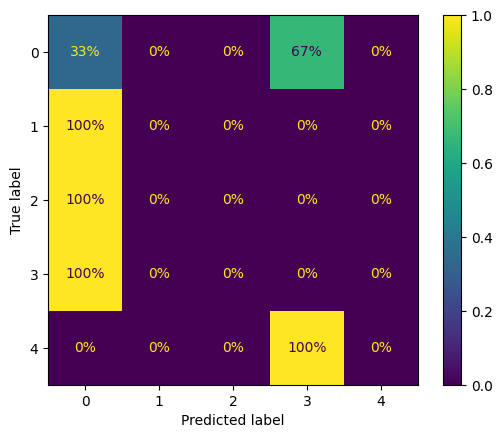

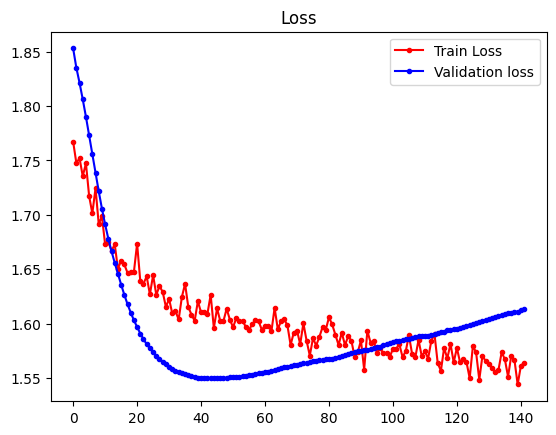

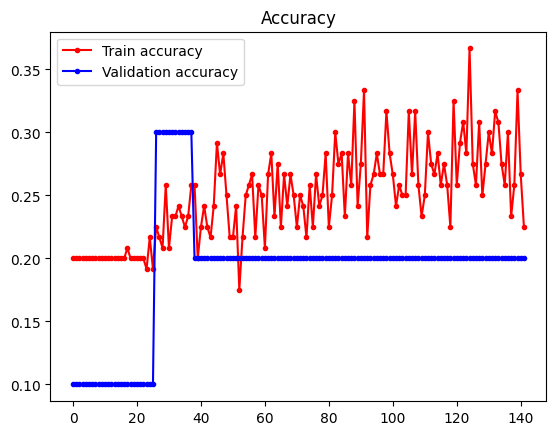

In [129]:
evaluate_model(model2,history2,test_df[predictors] , keras.utils.to_categorical(test_df['class']))

Here unfortunetelly we can see that model didnt learn anything and jsut predicted everything to class 0, the issue of overrepresentation was not present here, so the possible solution is that its much harder to make this kind of prediction based on KEGG dataset than on bacteria dataset. We will now move to best approach from previous analisis:

### Oversampling all of the classes in 5 class classification for both timepoints


In [131]:
train_val_df.shape, test_df.shape

((40, 241), (10, 241))

In [132]:
empty_class = pd.DataFrame(0, index=range(40),columns=train_val_df.columns)
#empty_class[] = np.random.rand(40, empty_class.shape[1])
empty_class['pond'] = 9


In [133]:
train_val_df_empty_class = pd.concat([train_val_df, empty_class], axis=0)

In [134]:
smote = SMOTE(random_state=111)
X = train_val_df_empty_class[predictors].values
y = train_val_df_empty_class['pond']

In [135]:
X.shape, y.shape

((80, 237), (80,))

In [136]:
X_smote, y_smote = smote.fit_resample(X, y)
y_smote.shape

(240,)

In [137]:
df_smote = pd.concat([pd.DataFrame(X_smote, columns=predictors), pd.DataFrame(y_smote, columns=['pond'])], axis=1)
df_smote_cleared = df_smote[df_smote['pond'] != 9]
df_smote_cleared.reset_index(drop=True, inplace=True)
print(df_smote_cleared.shape)
df_smote_cleared['pond'].value_counts()

(200, 238)


pond
1    40
0    40
4    40
3    40
2    40
Name: count, dtype: int64

(80, 237) (80,)
(240, 237) (240,)
Number of classes: 5
training for 1 subset


C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8375 - loss: 0.5940  
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/stepWARNING:tensorflow:5 out of the last 13 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000026FA6EA7380> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
predicted classes:       [1 0 4 2 4 1 1 0 3 0 0 0 0 1 0 0 1 1 1 1 1 3 2 2 2 2 2 2 1 3 3 1 3 4 4 4 4
 4 4 4]
true validation c

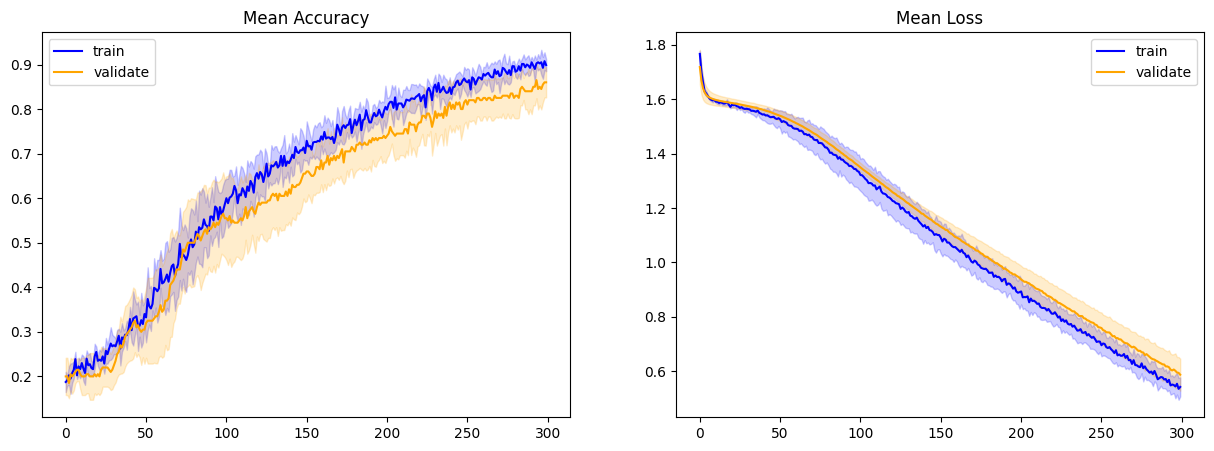

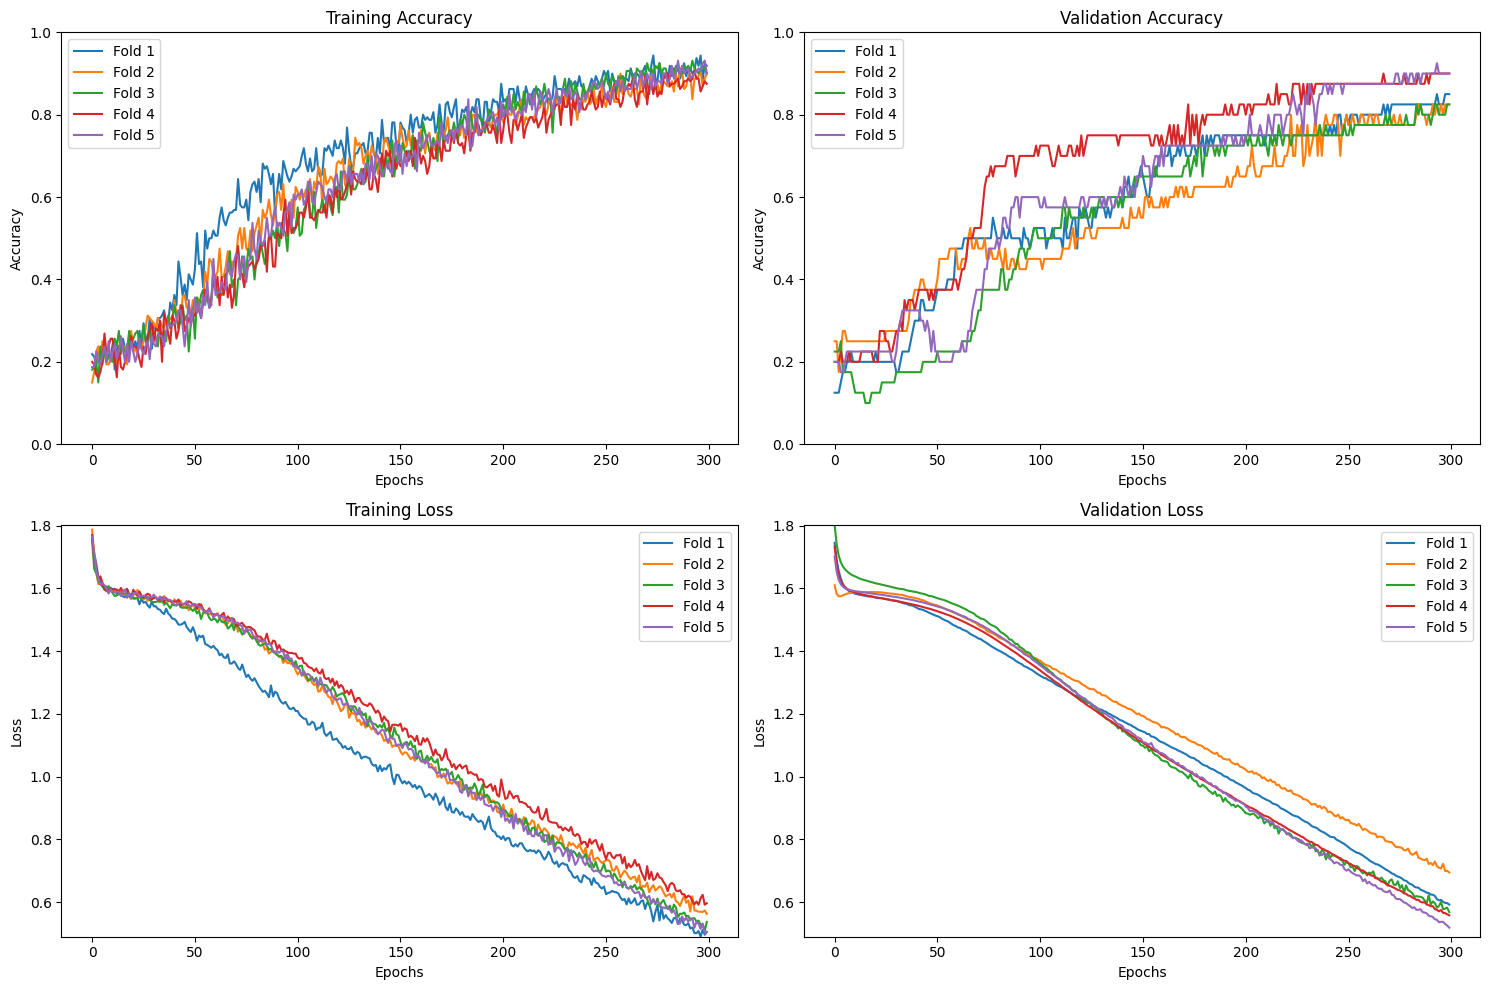

In [138]:
print(X.shape, y.shape)
print(X_smote.shape, y_smote.shape)

model3 = keras.Sequential()
model3.add(keras.layers.Dense(256,input_shape=(len(predictors),),activation='relu'))
model3.add(keras.layers.Dropout(rate=0.25))
model3.add(keras.layers.Dense(64, activation ='sigmoid'))
model3.add(keras.layers.Dropout(rate=0.25))
model3.add(keras.layers.Dense(16, activation ='sigmoid'))
model3.add(keras.layers.Dense(5, activation ='softmax'))

loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model3.compile(optimizer = optimizer, loss = loss, metrics=metrics)
crossvalidate(df_smote_cleared, model3, predictors, 'pond', kf)

In [139]:
X = df_smote_cleared[predictors].values
y = keras.utils.to_categorical(df_smote_cleared['pond'].values)
y_test = keras.utils.to_categorical(test_df['pond'].values)
X_test = test_df[predictors].values
reset_weights(model3)   

history5 = model3.fit(X, y, epochs=300, batch_size=5,validation_data=(X_test, y_test), verbose=1, callbacks=[es_callback])

Epoch 1/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1658 - loss: 1.7993 - val_accuracy: 0.1000 - val_loss: 1.8599
Epoch 2/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2035 - loss: 1.6961 - val_accuracy: 0.1000 - val_loss: 1.7841
Epoch 3/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1856 - loss: 1.6511 - val_accuracy: 0.0000e+00 - val_loss: 1.7446
Epoch 4/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2343 - loss: 1.6079 - val_accuracy: 0.1000 - val_loss: 1.7233
Epoch 5/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1826 - loss: 1.6096 - val_accuracy: 0.1000 - val_loss: 1.7096
Epoch 6/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2092 - loss: 1.6077 - val_accuracy: 0.1000 - val_loss: 1.6990
Epoch 7/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2844 - loss: 1.5854 - val_accuracy: 0.1000 - val_loss: 1.6911
Epoch 8/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2590 - loss: 1.5938 - val_accuracy: 0.1000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1000 - loss: 1.8599
[1.8598884344100952, 0.10000000149011612]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted values: [3 3 3 3 3 3 3 3 3 3]
True values: [1 2 4 0 2 0 0 2 1 3]


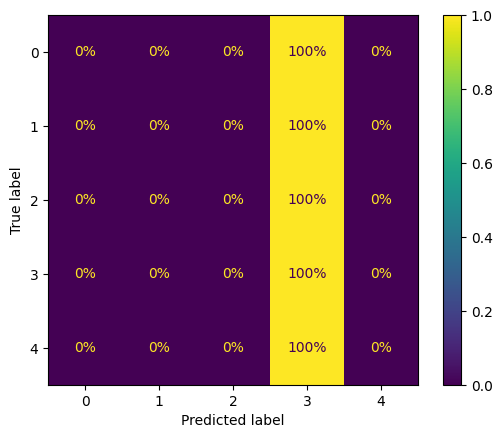

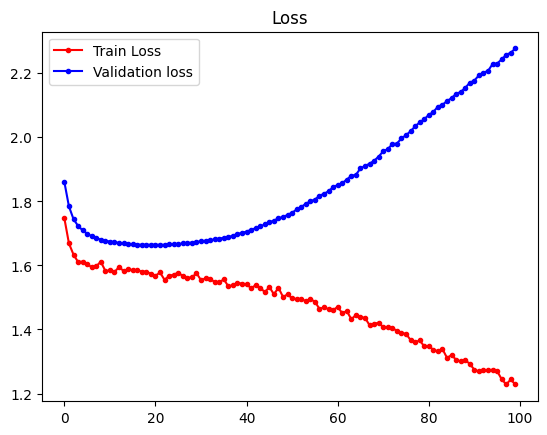

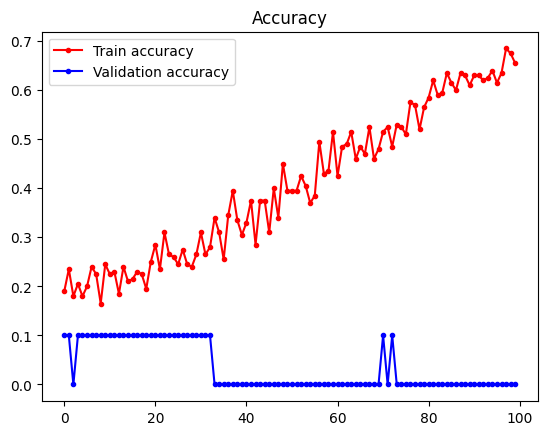

In [140]:
evaluate_model(model3, history5, X_test, y_test)

We can see simillar issues to previous classification approach, model is behaving much worse than for batcteria dataset. So if we are using same architecture results for KEGG paths dataset are much worse in comparison to bacteria dataset. Again issue of small number of original samples is probably causing most of the problems but we can see that model is having much harder time with KEGG dataset.